# Airbnb Pricing A/B Testing Project

# Project Aims
This project consisted of 2 sub-projects with distinct aims. **First, the focus of this Notebook, I sought to investigate features of Airbnb listings that are related to pricing and summarize key results through visualizations and a dashboard.** Second, I sought to investigate the features of Airbnb listings that are related to the number and ratings of reviews and summarize key results through visualizations and a second dashboard. Key methods included:
- Pulling relevant data and calculating basic metrics using SQL
- Using SQL to perform A/B tests to determine feature relationships
- Using Seaborn and plotly.io to create unique and interactive data visualizations
- Creating 2 dashboards of the main findings in Tableau

## Aims/Dashboard 1: Airbnb pricing analysis
*Analyze features of Airbnbs that are related to pricing*
### General pricing statistics:
- **Total listings:** *What is the total number of Airbnb listings in the dataset?*
- **Average daily price:** *What is the average Airbnb daily rate?*
- **Average service fee:** *What is the average service fee charged?*
- **Average total cost:** *What is the average total guest cost (price + service fee)?*
- **Price distribution:** *What is the median, quartiles, and range of pricing?*

### Geographic pricing:
#### Hypothesis - Manhattan properties command higher prices than other boroughs
- **Average price per neighborhood:** *Which neighborhood has the most expensive base rental rates?*
- **How service fees vary by property type/location:** *Do service fees vary systematically by location?*
- **Average total price per neighborhood:** *Total cost heatmap: Where are the most/least expensive areas for guests?*

### Property features impact on pricing:
#### Hypothesis 1: Entire homes are more pricy than single rooms or shared spaces
#### Hypothesis 2: Newer properties (post-2010) have higher pricing power
- **Room type:** *How much more do entire homes cost vs. private rooms?*
- **Room type/Location interaction:** *How much more do entire homes cost vs. private rooms by location?*
- **Property age (construction year):** *Do newer properties command price premiums?*
    - Method: A/B Test: Property age test
        - Groups:
            - Control (old homes): Construction year < 2010
            - Treatment (new homes): Construction year >= 2010
        - Primary metric: Average daily price difference
        - Secondary metric: Total guest cost (price + service fee)
    - *Followed up on initial results by examining how this changed based on borough and neighborhood*
 
### Host impact on pricing: 
#### Hypothesis 1: Professional hosts (5+ properties) price higher than casual hosts (=1 properties)
#### Hypothesis 2: Verified hosts can charge premium prices
- **Host portfolio size effect:** *Do multi-property hosts charge more per listing?*
    - Method: A/B Test: Professional vs. Casual Host Performance
        - Groups:
            - Control: calculated_host_listings_count = 1 (Casual hosts)
            - Treatment: calculated_host_listings_count >= 5 (Professional hosts)
        - Primary metric: Average daily price difference
        - Secondary metric: Total guest cost (price + service fee)
- **Verification premium:** *What price advantage does host verification provide?*
    - Method: A/B Test: Host Verification Premium Test
        - Groups:
            - Control: host_identity_verified = 'unconfirmed'
            - Treatment: host_identity_verified = 'verified'
        - Primary metric: Average daily price difference
        - Secondary metric: Total guest cost (price + service fee)
        
### Policy impact on pricing:
#### Hypothesis 1: Instant bookable properties command premium for convenience
#### Hypothesis 2: Stricter cancellation policies allow for higher pricing
- **Instant booking availability:** *Do instant bookable properties charge more?*
    - Method: A/B Test: Instant Booking Impact Analysis
        - Groups:
            - Control: instant_bookable = FALSE
            - Treatment: instant_bookable = TRUE
        - Primary metric: Average daily price difference
        - Secondary metric: Total guest cost
- **Cancellation policy strictness:** *How do flexible vs. strict policies affect pricing?*
    - Stricter cancellation policies transfer booking risk from the host to the guest. When hosts offer this risk protection to themselves, they can potentially charge a premium for the reduced uncertainty in their revenue.
    - Method: A/B Test: Cancellation Policy Strategy Test
        - Groups:
            - Control: cancellation_policy = 'strict'
            - Treatment A: cancellation_policy = 'moderate'
            - Treatment B: cancellation_policy = 'flexible'
        - Primary metric: Average daily price by policy type
   
## Cross-Dashboard Analysis
### Price-Review Correlation
#### Hypothesis: Higher-priced properties receive better review ratings due to quality expectations
- **Method:** Correlation analysis between price tiers and review performance
- **Price Tiers:** Budget (<100), Mid-range (100-200), Premium (200+)

## Study Limitations
- **Temporal:** Snapshot data, no longitudinal trends
- **Causality:** Observational study, correlation not causation
- **Selection Bias:** Only includes listed properties, not delisted ones
- **Proxy Metrics:** Reviews as proxy for bookings/satisfaction

## Dataset Overview
- **Source:** Airbnb Open Data (NYC)
- **Sample Size:** 102599 (listings)
- **Time Period:** 2012-07-11 to 2025-06-26 (4733 days)
- **Geographic Scope:** New York City (5 boroughs)

## Percentage Difference Thresholds Used:
- < 1%: Negligible - likely not worth acting on
- 1-3%: Small but potentially meaningful for high-volume businesses
- 3-5%: Moderate - often worth considering strategically
- 5-10%: Substantial - clear business impact
- 10%+: Large - significant business driver

# Set-up

## Load in packages

In [1]:
import pandas as pd
import numpy as np
import sqlite3
import plotly.express as px
import plotly.graph_objects as go

## Load in data
Variable info is outlined [here](https://docs.google.com/spreadsheets/d/1b_dvmyhb_kAJhUmv81rAxl4KcXn0Pymz/edit?gid=1967362979#gid=1967362979)

In [ ]:
#wd
os.chdir('/Users/agshivers/Documents/GitHub/airbnb_booking_ab-testing')

In [2]:
df = pd.read_csv('Airbnb_Open_Data.csv')

/Users/agshivers/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (25) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
# view data
df.head()

,id,NAME,host id,host_identity_verified,host name,neighbourhood group,neighbourhood,lat,long,country,...,service fee,minimum nights,number of reviews,last review,reviews per month,review rate number,calculated host listings count,availability 365,house_rules,license
0,1001254,Clean & quiet apt home by the park,80014485718,unconfirmed,Madaline,Brooklyn,Kensington,40.64749,-73.97237,United States,...,$193,10.0,9.0,10/19/2021,0.21,4.0,6.0,286.0,Clean up and treat the home the way you'd like...,NaN
1,1002102,Skylit Midtown Castle,52335172823,verified,Jenna,Manhattan,Midtown,40.75362,-73.98377,United States,...,$28,30.0,45.0,5/21/2022,0.38,4.0,2.0,228.0,Pet friendly but please confirm with me if the...,NaN
2,1002403,THE VILLAGE OF HARLEM....NEW YORK !,78829239556,NaN,Elise,Manhattan,Harlem,40.80902,-73.94190,United States,...,$124,3.0,0.0,NaN,NaN,5.0,1.0,352.0,"I encourage you to use my kitchen, cooking and...",NaN
3,1002755,NaN,85098326012,unconfirmed,Garry,Brooklyn,Clinton Hill,40.68514,-73.95976,United States,...,$74,30.0,270.0,7/5/2019,4.64,4.0,1.0,322.0,NaN,NaN
4,1003689,Entire Apt: Spacious Studio/Loft by central park,92037596077,verified,Lyndon,Manhattan,East Harlem,40.79851,-73.94399,United States,...,$41,10.0,9.0,11/19/2018,0.10,3.0,1.0,289.0,"Please no smoking in the house, porch or on th...",NaN


In [4]:
df.describe()

,id,host id,lat,long,Construction year,minimum nights,number of reviews,reviews per month,review rate number,calculated host listings count,availability 365
count,1.025990e+05,1.025990e+05,102591.000000,102591.000000,102385.000000,102190.000000,102416.000000,86720.000000,102273.000000,102280.000000,102151.000000
mean,2.914623e+07,4.925411e+10,40.728094,-73.949644,2012.487464,8.135845,27.483743,1.374022,3.279106,7.936605,141.133254
std,1.625751e+07,2.853900e+10,0.055857,0.049521,5.765556,30.553781,49.508954,1.746621,1.284657,32.218780,135.435024
min,1.001254e+06,1.236005e+08,40.499790,-74.249840,2003.000000,-1223.000000,0.000000,0.010000,1.000000,1.000000,-10.000000
25%,1.508581e+07,2.458333e+10,40.688740,-73.982580,2007.000000,2.000000,1.000000,0.220000,2.000000,1.000000,3.000000
50%,2.913660e+07,4.911774e+10,40.722290,-73.954440,2012.000000,3.000000,7.000000,0.740000,3.000000,1.000000,96.000000
75%,4.320120e+07,7.399650e+10,40.762760,-73.932350,2017.000000,5.000000,30.000000,2.000000,4.000000,2.000000,269.000000
max,5.736742e+07,9.876313e+10,40.916970,-73.705220,2022.000000,5645.000000,1024.000000,90.000000,5.000000,332.000000,3677.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102599 entries, 0 to 102598
Data columns (total 26 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   id                              102599 non-null  int64  
 1   NAME                            102349 non-null  object 
 2   host id                         102599 non-null  int64  
 3   host_identity_verified          102310 non-null  object 
 4   host name                       102193 non-null  object 
 5   neighbourhood group             102570 non-null  object 
 6   neighbourhood                   102583 non-null  object 
 7   lat                             102591 non-null  float64
 8   long                            102591 non-null  float64
 9   country                         102067 non-null  object 
 10  country code                    102468 non-null  object 
 11  instant_bookable                102494 non-null  object 
 12  cancellation_pol

In [6]:
df.shape

(102599, 26)

## Basic data cleaning

### Clean neighborhood borough names

In [7]:
df['neighbourhood group'].unique()

array(['Brooklyn', 'Manhattan', 'brookln', 'manhatan', 'Queens', nan,
       'Staten Island', 'Bronx'], dtype=object)

In [8]:
# dictionary of corrections
name_map = {
    "brookln": "Brooklyn",
    "manhatan": "Manhattan"
}

# apply corrections
df['neighbourhood group'] = df['neighbourhood group'].replace(name_map)

In [9]:
# verify
df['neighbourhood group'].unique()

array(['Brooklyn', 'Manhattan', 'Queens', nan, 'Staten Island', 'Bronx'],
      dtype=object)

In [10]:
df['neighbourhood'].unique()

array(['Kensington', 'Midtown', 'Harlem', 'Clinton Hill', 'East Harlem',
       'Murray Hill', 'Bedford-Stuyvesant', "Hell's Kitchen",
       'Upper West Side', 'Chinatown', 'South Slope', 'West Village',
       'Williamsburg', 'Fort Greene', 'Chelsea', 'Crown Heights',
       'Park Slope', 'Windsor Terrace', 'Inwood', 'East Village',
       'Greenpoint', 'Bushwick', 'Flatbush', 'Lower East Side',
       'Prospect-Lefferts Gardens', 'Long Island City', 'Kips Bay',
       'SoHo', 'Upper East Side', 'Prospect Heights',
       'Washington Heights', 'Woodside', 'Brooklyn Heights',
       'Carroll Gardens', 'Gowanus', 'Flatlands', 'Cobble Hill',
       'Flushing', 'Boerum Hill', 'Sunnyside', 'DUMBO', 'St. George',
       'Highbridge', 'Financial District', 'Ridgewood',
       'Morningside Heights', 'Jamaica', 'Middle Village', 'NoHo',
       'Ditmars Steinway', 'Flatiron District', 'Roosevelt Island',
       'Greenwich Village', 'Little Italy', 'East Flatbush',
       'Tompkinsville', 'Asto

## Create SQLite database and load data into it 
*Note that this is not necessary but just for the purposes of showcasing SQL skills/capabilities*

In [1]:
# connect to the database 
conn = sqlite3.connect('Airbnb_Open_Data.db')
df.to_sql('airbnb_data', conn, if_exists='replace', index=False)

NameError: name 'sqlite3' is not defined

# Project 1: Pricing Analysis

## Find basic metrics using SQL

In [17]:
# total listings
pd.read_sql('SELECT COUNT(*) AS total_listings FROM airbnb_data;', conn)

,total_listings
0,102599


In [27]:
# average daily price
q1 = '''
SELECT 
    COUNT(*) AS listings_with_price,
    AVG(CAST(REPLACE(REPLACE(price, '$', ''), ',', '') AS DECIMAL(10,2))) AS avg_daily_rate
FROM airbnb_data
WHERE price IS NOT NULL;
'''

pd.read_sql(q1, conn)

,listings_with_price,avg_daily_rate
0,102352,625.293536


In [34]:
# sanity check w pandas
df['price'] = (
    df['price']
    .replace('[\$,]', '', regex=True)  
    .replace('', np.nan)
    .pipe(pd.to_numeric, errors='coerce') 
)

df['price'].mean()

<>:3: SyntaxWarning: invalid escape sequence '\$'
<>:3: SyntaxWarning: invalid escape sequence '\$'
/var/folders/cl/dyx4rnd54ng0d55bnxrkvyd00000gr/T/ipykernel_29517/3496628336.py:3: SyntaxWarning: invalid escape sequence '\$'
  .replace('[\$,]', '', regex=True)


625.2935360325152

In [28]:
# number of listings without price
q2 = '''
SELECT
    total_listings - listings_with_price AS listings_no_price
FROM (
    SELECT
        COUNT(*) AS total_listings, 
        COUNT(price) AS listings_with_price 
    FROM airbnb_data
)
'''

pd.read_sql(q2, conn)

,listings_no_price
0,247


In [38]:
# average service fee 
q3 = '''
SELECT
    COUNT(*) AS listings_with_service_fee,
    AVG(CAST(REPLACE(REPLACE(`service fee`, '$', ''), ',', '') AS DECIMAL(10,2))) AS avg_service_fee
FROM airbnb_data
WHERE `service fee` IS NOT NULL;
'''

pd.read_sql(q3, conn)

,listings_with_service_fee,avg_service_fee
0,102326,125.026924


In [33]:
# sanity check w pandas
df['service fee'] = (
    df['service fee']
    .replace('[\$,]', '', regex=True)  
    .replace('', np.nan)
    .pipe(pd.to_numeric, errors='coerce') 
)

df['service fee'].mean()

<>:4: SyntaxWarning: invalid escape sequence '\$'
<>:4: SyntaxWarning: invalid escape sequence '\$'
/var/folders/cl/dyx4rnd54ng0d55bnxrkvyd00000gr/T/ipykernel_29517/3222857510.py:4: SyntaxWarning: invalid escape sequence '\$'
  .replace('[\$,]', '', regex=True)


125.02692375349373

In [44]:
# average total cost
q4 = '''
SELECT 
    COUNT(*) AS listings_with_both_fees,
    AVG(CAST(REPLACE(REPLACE(price, '$', ''), ',', '') AS DECIMAL(10,2)) +
        CAST(REPLACE(REPLACE(`service fee`, '$', ''), ',', '') AS DECIMAL(10,2))) AS avg_total_cost
FROM airbnb_data
WHERE price IS NOT NULL AND `service fee` IS NOT NULL;
'''

pd.read_sql(q4, conn)

,listings_with_both_fees,avg_total_cost
0,102113,750.22669


In [46]:
# sanity check w pandas
df['total_cost'] = df['price']+df['service fee']
print(df[['price', 'service fee', 'total_cost']].head(3))
df.total_cost.mean()

   price  service fee  total_cost
0  966.0        193.0      1159.0
1  142.0         28.0       170.0
2  620.0        124.0       744.0


750.2266900394661

In [51]:
# min and max price
q5 = '''
SELECT 
    MIN(CAST(REPLACE(REPLACE(price, '$', ''), ',', '') AS REAL)) AS min_price,
    MAX(CAST(REPLACE(REPLACE(price, '$', ''), ',', '') AS REAL)) AS max_price
FROM airbnb_data 
WHERE price IS NOT NULL AND CAST(REPLACE(REPLACE(price, '$', ''), ',', '') AS REAL) > 0;
'''

pd.read_sql(q5, conn)

,min_price,max_price
0,50.0,1200.0


In [56]:
# min and max service fee
q6 = '''
SELECT 
    MIN(CAST(REPLACE(REPLACE(`service fee`, '$', ''), ',', '') AS REAL)) AS min_service_fee,
    MAX(CAST(REPLACE(REPLACE(`service fee`, '$', ''), ',', '') AS REAL)) AS max_service_fee
FROM airbnb_data 
WHERE `service fee` IS NOT NULL AND CAST(REPLACE(REPLACE(`service fee`, '$', ''), ',', '') AS REAL) > 0;
'''

pd.read_sql(q6, conn)

,min_service_fee,max_service_fee
0,10.0,240.0


In [58]:
# min and max total cost
q7 = '''
SELECT 
    MIN(CAST(REPLACE(REPLACE(price, '$', ''), ',', '') AS REAL) + CAST(REPLACE(REPLACE(`service fee`, '$', ''), ',', '') AS REAL)) AS min_total_cost,
    MAX(CAST(REPLACE(REPLACE(price, '$', ''), ',', '') AS REAL) + CAST(REPLACE(REPLACE(`service fee`, '$', ''), ',', '') AS REAL)) AS max_total_cost
FROM airbnb_data 
WHERE price IS NOT NULL AND `service fee` IS NOT NULL AND CAST(REPLACE(REPLACE(`service fee`, '$', ''), ',', '') AS REAL) > 0;
'''

pd.read_sql(q7, conn)

,min_total_cost,max_total_cost
0,60.0,1440.0


In [59]:
df['last review'].unique()[:50]

array(['2021-10-19T00:00:00.000000000', '2022-05-21T00:00:00.000000000',
                                 'NaT', '2019-07-05T00:00:00.000000000',
       '2018-11-19T00:00:00.000000000', '2019-06-22T00:00:00.000000000',
       '2017-10-05T00:00:00.000000000', '2019-06-24T00:00:00.000000000',
       '2017-07-21T00:00:00.000000000', '2019-06-09T00:00:00.000000000',
       '2019-06-23T00:00:00.000000000', '2018-10-31T00:00:00.000000000',
       '2019-06-29T00:00:00.000000000', '2019-06-28T00:00:00.000000000',
       '2019-07-01T00:00:00.000000000', '2021-12-28T00:00:00.000000000',
       '2019-01-01T00:00:00.000000000', '2019-07-02T00:00:00.000000000',
       '2019-06-19T00:00:00.000000000', '2017-08-13T00:00:00.000000000',
       '2019-06-15T00:00:00.000000000', '2019-04-19T00:00:00.000000000',
       '2019-06-01T00:00:00.000000000', '2019-06-14T00:00:00.000000000',
       '2019-05-12T00:00:00.000000000', '2019-06-21T00:00:00.000000000',
       '2019-05-27T00:00:00.000000000', '2018-09-30

In [68]:
# find bad date rows, those in the future
bad = df[df['last review'] > pd.Timestamp.today()]
print(bad)

df[df['last review'].isin([pd.Timestamp('2058-06-16'), pd.Timestamp('2040-06-16'), pd.Timestamp('2026-03-28')])]

          id                              NAME      host id  \
255  1142173       Beautiful Landmarked Duplex  87944779917   
318  1176967                               NaN  70084472212   
483  1268097  Modern Space in Charming Pre-war  13746585241   

    host_identity_verified host name neighbourhood group neighbourhood  \
255                    NaN     Baker            Brooklyn    Greenpoint   
318               verified    Barnes            Brooklyn    Greenpoint   
483               verified  Adelaide           Manhattan        Harlem   

          lat      long        country  ... service fee minimum nights  \
255  40.72945 -73.95511  United States  ...       $168             3.0   
318  40.72488 -73.95018  United States  ...       $184             2.0   
483  40.82411 -73.94934  United States  ...       $144             2.0   

    number of reviews last review  reviews per month review rate number  \
255             124.0  2058-06-16               1.22                4.0   
318

,id,NAME,host id,host_identity_verified,host name,neighbourhood group,neighbourhood,lat,long,country,...,service fee,minimum nights,number of reviews,last review,reviews per month,review rate number,calculated host listings count,availability 365,house_rules,license
255,1142173,Beautiful Landmarked Duplex,87944779917,NaN,Baker,Brooklyn,Greenpoint,40.72945,-73.95511,United States,...,$168,3.0,124.0,2058-06-16,1.22,4.0,3.0,230.0,No rules per say. I just ask that you respect ...,NaN
483,1268097,Modern Space in Charming Pre-war,13746585241,verified,Adelaide,Manhattan,Harlem,40.82411,-73.94934,United States,...,$144,2.0,41.0,2040-06-16,0.43,3.0,2.0,47.0,NaN,NaN


In [69]:
# convert to datetime 
df['last review'] = pd.to_datetime(df['last review'], errors='coerce')

# then get earliest and latest
earliest = df[~df['last review'].isin([pd.Timestamp('2058-06-16'), pd.Timestamp('2040-06-16'), pd.Timestamp('2026-03-28')])]['last review'].min()
latest = df[~df['last review'].isin([pd.Timestamp('2058-06-16'), pd.Timestamp('2040-06-16'), pd.Timestamp('2026-03-28')])]['last review'].max()
date_range = latest - earliest

print("Earliest date:", earliest)
print("Latest date:", latest)
print("Date range:", date_range)

Earliest date: 2012-07-11 00:00:00
Latest date: 2025-06-26 00:00:00
Date range: 4733 days 00:00:00


# Data Analysis

## Geographic pricing

### Average price by borough

In [71]:
q8 = '''
SELECT 
    `neighbourhood group`,
    COUNT(*) AS listings_count,
    AVG(CAST(REPLACE(REPLACE(price, '$', ''), ',', '') AS REAL)) AS avg_price,
    MIN(CAST(REPLACE(REPLACE(price, '$', ''), ',', '') AS REAL)) AS min_price,
    MAX(CAST(REPLACE(REPLACE(price, '$', ''), ',', '') AS REAL)) AS max_price
FROM airbnb_data 
WHERE price IS NOT NULL AND `neighbourhood group` IS NOT NULL AND CAST(REPLACE(REPLACE(price, '$', ''), ',', '') AS REAL) > 0
GROUP BY `neighbourhood group`
ORDER BY avg_price DESC;
'''
pd.read_sql(q8, conn)

# manhattan has the most listings, but Queens is the most expensive, on average

,neighbourhood group,listings_count,avg_price,min_price,max_price
0,Queens,13234,630.207647,50.0,1200.0
1,Bronx,2705,627.766359,50.0,1200.0
2,Brooklyn,41750,626.561078,50.0,1200.0
3,Staten Island,952,624.490546,50.0,1200.0
4,Manhattan,43683,622.436508,50.0,1200.0


In [79]:
df[df['neighbourhood group']=='Manhattan']['price'].max()

1200.0

### Average service fee by borough

In [82]:
q9 = '''
SELECT 
    `neighbourhood group`,
    COUNT(*) AS listings_count,
    AVG(CAST(REPLACE(REPLACE(`service fee`, '$', ''), ',', '') AS REAL)) AS avg_service_fee,
    MIN(CAST(REPLACE(REPLACE(`service fee`, '$', ''), ',', '') AS REAL)) AS min_service_fee,
    MAX(CAST(REPLACE(REPLACE(`service fee`, '$', ''), ',', '') AS REAL)) AS max_service_fee
FROM airbnb_data 
WHERE `service fee` IS NOT NULL AND `neighbourhood group` IS NOT NULL AND CAST(REPLACE(REPLACE(price, '$', ''), ',', '') AS REAL) > 0
GROUP BY `neighbourhood group`
ORDER BY avg_service_fee DESC;
'''
pd.read_sql(q9, conn)

# manhattan has the most listings, but Queens is still the most expensive, on average

,neighbourhood group,listings_count,avg_service_fee,min_service_fee,max_service_fee
0,Queens,13201,126.025150,10.0,240.0
1,Bronx,2700,125.541481,10.0,240.0
2,Brooklyn,41649,125.265961,10.0,240.0
3,Staten Island,950,124.858947,10.0,240.0
4,Manhattan,43585,124.490559,10.0,240.0


### Average total cost by borough

In [84]:
q10 = '''
SELECT 
    `neighbourhood group`,
    COUNT(*) AS listings_count,
    AVG(CAST(REPLACE(REPLACE(price, '$', ''), ',', '') AS REAL) + CAST(REPLACE(REPLACE(`service fee`, '$', ''), ',', '') AS REAL)) AS avg_total_cost,
    MIN(CAST(REPLACE(REPLACE(price, '$', ''), ',', '') AS REAL) + CAST(REPLACE(REPLACE(`service fee`, '$', ''), ',', '') AS REAL)) AS min_total_cost,
    MAX(CAST(REPLACE(REPLACE(price, '$', ''), ',', '') AS REAL) + CAST(REPLACE(REPLACE(`service fee`, '$', ''), ',', '') AS REAL)) AS max_total_cost
FROM airbnb_data 
WHERE `service fee` IS NOT NULL AND price IS NOT NULL AND `neighbourhood group` IS NOT NULL AND CAST(REPLACE(REPLACE(price, '$', ''), ',', '') AS REAL) > 0
GROUP BY `neighbourhood group`
ORDER BY avg_total_cost DESC;
'''
pd.read_sql(q10, conn)

# manhattan has the most listings, but Queens is still the most expensive, on average

,neighbourhood group,listings_count,avg_total_cost,min_total_cost,max_total_cost
0,Queens,13201,756.154003,60.0,1440.0
1,Bronx,2700,753.220000,60.0,1440.0
2,Brooklyn,41649,751.591371,60.0,1440.0
3,Staten Island,950,749.147368,60.0,1440.0
4,Manhattan,43585,746.939888,60.0,1440.0


## Property features and pricing

### Average price per room type

In [91]:
q11 = '''
SELECT 
    `room type`,
    COUNT(*) AS listings_count,
    AVG(CAST(REPLACE(REPLACE(price, '$', ''), ',', '') AS REAL)) AS avg_daily_price,
    AVG(CAST(REPLACE(REPLACE(price, '$', ''), ',', '') AS REAL) + CAST(REPLACE(REPLACE(`service fee`, '$', ''), ',', '') AS REAL)) AS avg_total_cost
FROM airbnb_data 
WHERE price IS NOT NULL AND `service fee` IS NOT NULL AND `room type` IS NOT NULL AND CAST(REPLACE(REPLACE(price, '$', ''), ',', '') AS REAL) > 0
GROUP BY `room type`
ORDER BY avg_daily_price DESC;
'''

pd.read_sql(q11, conn)

,room type,listings_count,avg_daily_price,avg_total_cost
0,Hotel room,114,663.561404,796.280702
1,Shared room,2215,633.967494,760.759368
2,Private room,46330,624.958990,749.949881
3,Entire home/apt,53454,624.941408,749.931941


### Room type/Location interaction

In [88]:
# room type breakdown by borough
q_room_type = '''
SELECT 
    `neighbourhood group`,
    `room type`,
    COUNT(*) AS listings,
    AVG(CAST(REPLACE(REPLACE(price, '$', ''), ',', '') AS REAL)) AS avg_price
FROM airbnb_data 
WHERE price IS NOT NULL 
    AND `neighbourhood group` IS NOT NULL
    AND `room type` IS NOT NULL
    AND CAST(REPLACE(REPLACE(price, '$', ''), ',', '') AS REAL) > 0
GROUP BY `neighbourhood group`, `room type`
ORDER BY `neighbourhood group`, avg_price DESC;
'''

pd.read_sql(q_room_type, conn)

# room type is a bigger influence on price than location

,neighbourhood group,room type,listings,avg_price
0,Bronx,Private room,1569,634.710644
1,Bronx,Entire home/apt,1019,620.232581
2,Bronx,Shared room,117,600.256410
3,Brooklyn,Hotel room,8,736.125000
4,Brooklyn,Shared room,820,634.317073
5,Brooklyn,Entire home/apt,20532,626.896406
6,Brooklyn,Private room,20390,625.868514
7,Manhattan,Hotel room,100,681.870000
8,Manhattan,Shared room,904,632.522124
9,Manhattan,Entire home/apt,26401,623.147570


### A/B Test: Pricing difference between newer and older homes

In [96]:
print('oldest year: ', df['Construction year'].min())
print('newest year: ', df['Construction year'].max())

oldest year:  2003.0
newest year:  2022.0


In [97]:
# A/B Test: Property age impact on pricing
property_ab_test = '''
SELECT 
    CASE 
        WHEN `Construction year` <= 2010 THEN 'Control (Built 2010 or earlier)'
        WHEN `Construction year` >= 2011 THEN 'Treatment (Built 2011 or later)'
        ELSE 'Unknown'
    END AS test_group,
    COUNT(*) AS sample_size,
    AVG(CAST(REPLACE(REPLACE(price, '$', ''), ',', '') AS REAL)) AS avg_daily_price,
    AVG(CAST(REPLACE(REPLACE(price, '$', ''), ',', '') AS REAL) + CAST(REPLACE(REPLACE(`service fee`, '$', ''), ',', '') AS REAL)) AS avg_total_cost,
    MIN(`Construction year`) AS min_year,
    MAX(`Construction year`) AS max_year
FROM airbnb_data 
WHERE price IS NOT NULL 
    AND `service fee` IS NOT NULL
    AND `Construction year` IS NOT NULL
    AND CAST(REPLACE(REPLACE(price, '$', ''), ',', '') AS REAL) > 0
GROUP BY test_group
ORDER BY avg_daily_price DESC;
'''
pd.read_sql(property_ab_test, conn)

,test_group,sample_size,avg_daily_price,avg_total_cost,min_year,max_year
0,Control (Built 2010 or earlier),40984,627.238117,752.684340,2003.0,2010.0
1,Treatment (Built 2011 or later),60925,623.903964,748.686943,2011.0,2022.0


In [54]:
control_price = 627.24
treatment_price = 623.90

price_difference = treatment_price-control_price
percentage_change = (price_difference/control_price)*100

print(f"Price difference: ${price_difference:.2f}")
print(f"Percentage change: {percentage_change:.2f}%")
# newer homes cost 0.53% LESS than older homes... not siginifcant difference though


control_tc = 752.68
treatment_tc = 748.69

print(((treatment_tc-control_tc)/control_tc)*100)
# negligible differences

Price difference: $-3.34
Percentage change: -0.53%
-0.5301057554339023


### Is this due to location? Maybe older homes are in more centrally-located, desirable areas

In [76]:
# see if the age effect varies by borough
q_age_location = '''
SELECT 
    `neighbourhood group`,
    CASE 
        WHEN `Construction year` <= 2010 THEN 'Older (≤2010)'
        WHEN `Construction year` >= 2011 THEN 'Newer (≥2011)'
    END AS property_age,
    COUNT(*) AS sample_size,
    AVG(CAST(REPLACE(REPLACE(price, '$', ''), ',', '') AS REAL)) AS avg_price,
    AVG(`Construction year`) AS avg_construction_year
FROM airbnb_data 
WHERE price IS NOT NULL 
    AND `Construction year` IS NOT NULL
    AND `neighbourhood group` IS NOT NULL
    AND CAST(REPLACE(REPLACE(price, '$', ''), ',', '') AS REAL) > 0
GROUP BY `neighbourhood group`, property_age
ORDER BY `neighbourhood group`, property_age;
'''
pd.read_sql(q_age_location, conn)

,neighbourhood group,property_age,sample_size,avg_price,avg_construction_year
0,Bronx,Newer (≥2011),1607,632.375856,2016.626633
1,Bronx,Older (≤2010),1095,621.552511,2006.368950
2,Brooklyn,Newer (≥2011),25016,624.150264,2016.507715
3,Brooklyn,Older (≤2010),16639,630.229461,2006.511569
4,Manhattan,Newer (≥2011),26048,621.430590,2016.478924
5,Manhattan,Older (≤2010),17546,623.986835,2006.537216
6,Queens,Newer (≥2011),7862,629.810735,2016.574663
7,Queens,Older (≤2010),5355,631.134267,2006.483287
8,Staten Island,Newer (≥2011),511,627.831703,2016.338552
9,Staten Island,Older (≤2010),440,621.470455,2006.363636


In [77]:
# for Bronx and Staten Island, newer rentals ARE noticably more expensive
# however, the sample size for these two locations was MUCH smaller than the other boroughs
# in Manhattan, Queens, and Brooklyn, older rentals are slightly more expensive, but not by much
# before, the massive number of newer properties in Brooklyn/Manhattan (where older properties have slight premiums) drove down the overall average for newer properties
# Borough-Specific Patterns:
    # Outer Boroughs (Bronx, Staten Island): Newer construction commands premium (likely due to better amenities, modern design)
    # Core Boroughs (Manhattan, Brooklyn): Older properties have slight premium (established neighborhoods, character, location)
    # Queens: Age doesn't matter much for pricing

In [78]:
# plot 
# query for clean geographic data for mapping
q_map_data = '''
SELECT 
    `neighbourhood group`,
    neighbourhood,
    AVG(lat) AS avg_latitude,
    AVG(long) AS avg_longitude,
    COUNT(*) AS total_properties,
    AVG(CAST(REPLACE(REPLACE(price, '$', ''), ',', '') AS REAL)) AS avg_price,
    SUM(CASE WHEN `Construction year` <= 2010 THEN 1 ELSE 0 END) AS older_count,
    SUM(CASE WHEN `Construction year` >= 2011 THEN 1 ELSE 0 END) AS newer_count,
    AVG(CASE WHEN `Construction year` <= 2010 
        THEN CAST(REPLACE(REPLACE(price, '$', ''), ',', '') AS REAL) END) AS avg_price_older,
    AVG(CASE WHEN `Construction year` >= 2011 
        THEN CAST(REPLACE(REPLACE(price, '$', ''), ',', '') AS REAL) END) AS avg_price_newer
FROM airbnb_data 
WHERE lat IS NOT NULL 
    AND long IS NOT NULL
    AND neighbourhood IS NOT NULL
    AND price IS NOT NULL
    AND `Construction year` IS NOT NULL
    AND CAST(REPLACE(REPLACE(price, '$', ''), ',', '') AS REAL) > 0
GROUP BY `neighbourhood group`, neighbourhood
HAVING COUNT(*) >= 30
ORDER BY `neighbourhood group`, neighbourhood;
'''

map_data = pd.read_sql(q_map_data, conn)
print(f"Loaded {len(map_data)} neighborhoods")
map_data.head()

Loaded 155 neighborhoods


,neighbourhood group,neighbourhood,avg_latitude,avg_longitude,total_properties,avg_price,older_count,newer_count,avg_price_older,avg_price_newer
0,Bronx,Allerton,40.864776,-73.859510,95,638.494737,38,57,468.842105,751.596491
1,Bronx,Belmont,40.854865,-73.887518,45,672.488889,16,29,668.437500,674.724138
2,Bronx,Bronxdale,40.854989,-73.866015,47,574.170213,19,28,537.736842,598.892857
3,Bronx,City Island,40.848072,-73.787053,41,647.292683,16,25,636.562500,654.160000
4,Bronx,Claremont Village,40.839182,-73.909056,59,636.372881,26,33,652.269231,623.848485


In [79]:
map_data['price_premium_older'] = map_data['avg_price_older']-map_data['avg_price_newer']
map_data['percent_older'] = (map_data['older_count']/map_data['total_properties'])*100
manhattan_center_lat = 40.7589
manhattan_center_lon = -73.9851

map_data['distance_from_center'] = ((map_data['avg_latitude'] - manhattan_center_lat)**2 + (map_data['avg_longitude'] - manhattan_center_lon)**2)**0.5

# clean up any null values
map_data = map_data.dropna(subset=['avg_price_older', 'avg_price_newer'])

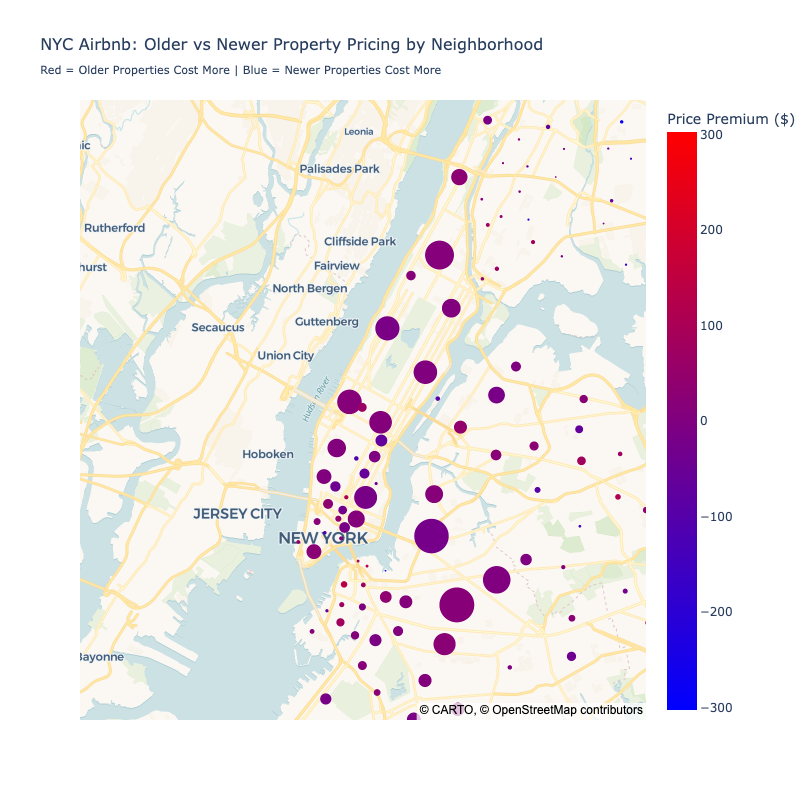

In [80]:
fig = px.scatter_map(
    map_data,
    lat="avg_latitude",
    lon="avg_longitude", 
    color="price_premium_older",
    size="total_properties",
    hover_name="neighbourhood",
    hover_data={
        "neighbourhood group": True,
        "avg_price_older": ":.0f",
        "avg_price_newer": ":.0f", 
        "price_premium_older": ":.0f",
        "total_properties": True,
        "distance_from_center": ":.3f",
        "avg_latitude": False,
        "avg_longitude": False
    },
    color_continuous_scale="Bluered",
    color_continuous_midpoint=0,
    size_max=25,
    zoom=10.5,
    center={"lat": 40.7589, "lon": -73.9851},
    title="NYC Airbnb: Older vs Newer Property Pricing by Neighborhood<br><sub>Red = Older Properties Cost More | Blue = Newer Properties Cost More</sub>",
    labels={
        "price_premium_older": "Older Property Premium ($)",
        "total_properties": "Properties Count"
    },
    width=1200,
    height=800
)

fig.update_traces(
    marker=dict(
        opacity=1.0
    )
)

fig.update_layout(
    font_size=12,
    title_font_size=16,
    coloraxis_colorbar=dict(
        title="Price Premium ($)"
    )
)

## Host impact on pricing

### A/B Test: Pricing difference between casual (= 1) and professional (5+) hosts
Alternate Hypothesis: Professional hosts (5+ properties) price higher than casual hosts (1 property)
- **Host portfolio size effect:** *Do multi-property hosts charge more per listing?*
- Groups:
    - Control: calculated_host_listings_count = 1 (Casual hosts)
    - Treatment: calculated_host_listings_count >= 5 (Professional hosts)
- Primary metric: Average daily price difference
- Secondary metric: Total guest cost (price + service fee)

1.0
1.0
2.0
1.0
-0.5
3.5
17829


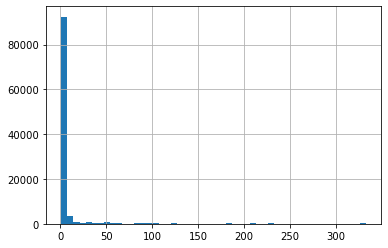

In [38]:
# some quick exploratory to see distribution of properties owned
df['calculated host listings count'].hist(bins=50)

q1 = df['calculated host listings count'].quantile(0.25)
median = df['calculated host listings count'].quantile(0.50)  
q3 = df['calculated host listings count'].quantile(0.75)
iqr = q3 - q1

lower_bound = q1-1.5*iqr
upper_bound = q3+1.5*iqr

outliers = df[(df['calculated host listings count'] < lower_bound) | (df['calculated host listings count'] > upper_bound)]['calculated host listings count']

print(q1)
print(median)
print(q3)
print(iqr)
print(lower_bound)
print(upper_bound)
print(outliers.count())

# most hosts are casual with just 1

In [39]:
q_portfolio_distribution = '''
SELECT 
    `calculated host listings count` AS portfolio_size,
    COUNT(*) AS host_count,
    COUNT(*) * 100.0/(SELECT COUNT(*) FROM airbnb_data WHERE `calculated host listings count` IS NOT NULL) AS percentage
FROM airbnb_data 
WHERE `calculated host listings count` IS NOT NULL
GROUP BY `calculated host listings count`
ORDER BY `calculated host listings count`;
'''

distribution = pd.read_sql(q_portfolio_distribution, conn)
print("Portfolio Size Distribution:")
distribution.head(20)

Portfolio Size Distribution:


,portfolio_size,host_count,percentage
0,1.0,63429,62.015057
1,2.0,14445,14.122996
2,3.0,6577,6.430387
3,4.0,3552,3.472820
4,5.0,1995,1.950528
5,6.0,1477,1.444075
6,7.0,996,0.973797
7,8.0,958,0.936645
8,9.0,543,0.530896
9,10.0,516,0.504497


In [50]:
# A/B Test: Professional vs Casual Host Pricing
q_host_port_ab_test = '''
SELECT 
    CASE 
        WHEN `calculated host listings count` = 1 THEN 'Control (Casual: ≤2 properties)'
        WHEN `calculated host listings count` >= 5 THEN 'Treatment (Professional: 5+ properties)'
        ELSE 'Excluded (3-4 properties)'
    END AS test_group,
    COUNT(*) AS sample_size,
    AVG(CAST(REPLACE(REPLACE(price, '$', ''), ',', '') AS REAL)) AS avg_daily_price,
    AVG(CAST(REPLACE(REPLACE(price, '$', ''), ',', '') AS REAL) + CAST(REPLACE(REPLACE(`service fee`, '$', ''), ',', '') AS REAL)) AS avg_total_cost,
    MIN(CAST(REPLACE(REPLACE(price, '$', ''), ',', '') AS REAL)) AS min_price,
    MAX(CAST(REPLACE(REPLACE(price, '$', ''), ',', '') AS REAL)) AS max_price,
    AVG(`calculated host listings count`) AS avg_portfolio_size
FROM airbnb_data 
WHERE price IS NOT NULL 
    AND `service fee` IS NOT NULL
    AND `calculated host listings count` IS NOT NULL
    AND CAST(REPLACE(REPLACE(price, '$', ''), ',', '') AS REAL) > 0
    AND (`calculated host listings count` <= 2 OR `calculated host listings count` >= 5)  -- Only include our test groups
GROUP BY test_group
ORDER BY avg_daily_price DESC;
'''

pd.read_sql(q_host_port_ab_test, conn)

,test_group,sample_size,avg_daily_price,avg_total_cost,min_price,max_price,avg_portfolio_size
0,Excluded (3-4 properties),14390,629.827380,755.793259,50.0,1200.0,2.000000
1,Treatment (Professional: 5+ properties),14182,626.171203,751.411367,50.0,1200.0,48.050134
2,Control (Casual: ≤2 properties),63137,624.610925,749.532952,50.0,1200.0,1.000000


In [47]:
# price percentage difference
casual_price = 624.61
prof_price = 626.17

print("Percentage Differences:")
print(((prof_price-casual_price)/casual_price)*100)


# total cost percentage difference
casual_tc = 749.53
prof_tc = 751.41

print("Percentage Differences:")
print(((prof_tc-casual_tc)/casual_tc)*100)

# negligible differences

Percentage Differences:
0.24975584764892417
Percentage Differences:
0.2508238496124232


### A/B Test: Pricing difference between verified and unverified hosts
Alternate Hypothesis: Verified hosts can charge premium prices
- **Verification premium:** *What price advantage does host verification provide?*
- Groups:
    - Control: host_identity_verified = 'unconfirmed'
    - Treatment: host_identity_verified = 'verified'
- Primary metric: Average daily price difference
- Secondary metric: Total guest cost (price + service fee)

In [51]:
# A/B Test: Pricing premium for verified hosts
q_verified_ab_test = '''
SELECT 
    CASE 
        WHEN host_identity_verified = 'unconfirmed' THEN 'Control (Unconfirmed identity)'
        WHEN host_identity_verified = 'verified' THEN 'Treatment (Verified identity)'
    END AS test_group,
    COUNT(*) AS sample_size,
    AVG(CAST(REPLACE(REPLACE(price, '$', ''), ',', '') AS REAL)) AS avg_daily_price,
    AVG(CAST(REPLACE(REPLACE(price, '$', ''), ',', '') AS REAL) + CAST(REPLACE(REPLACE(`service fee`, '$', ''), ',', '') AS REAL)) AS avg_total_cost,
    MIN(CAST(REPLACE(REPLACE(price, '$', ''), ',', '') AS REAL)) AS min_price,
    MAX(CAST(REPLACE(REPLACE(price, '$', ''), ',', '') AS REAL)) AS max_price
FROM airbnb_data 
WHERE price IS NOT NULL 
    AND `service fee` IS NOT NULL
    AND host_identity_verified IS NOT NULL
    AND CAST(REPLACE(REPLACE(price, '$', ''), ',', '') AS REAL) > 0
GROUP BY test_group
ORDER BY avg_daily_price DESC;
'''

pd.read_sql(q_verified_ab_test, conn)

,test_group,sample_size,avg_daily_price,avg_total_cost,min_price,max_price
0,Control (Unconfirmed identity),50970,626.516186,751.820208,50.0,1200.0
1,Treatment (Verified identity),50859,623.778840,748.535264,50.0,1200.0


In [52]:
# price percentage difference
verified_price = 623.78
unconfirmed_price = 626.52

print("Percentage Differences:")
print(((verified_price-unconfirmed_price)/unconfirmed_price)*100)


# total cost percentage difference
verified_tc = 748.54
unconfirmed_tc = 751.82

print("Percentage Differences:")
print(((verified_tc-unconfirmed_tc)/unconfirmed_tc)*100)

# negligible differences

Percentage Differences:
-0.4373363978803564
Percentage Differences:
-0.4362746402064439


## Policy impact on pricing:

### A/B Test: Pricing difference between instant-bookable properties and non-instant-bookable properties
- Alternate hypothesis: Instant bookable properties command premium for convenience
- Groups:
    - Control: instant_bookable = FALSE
    - Treatment: instant_bookable = TRUE
- Primary metric: Average daily price difference
- Secondary metric: Total guest cost

In [21]:
q_ins_book_ab_test = '''
SELECT
    instant_bookable AS test_group,
    COUNT(*) AS sample_size, 
    AVG(CAST(REPLACE(REPLACE(price, '$', ''), ',', '') AS REAL)) AS avg_daily_price,
    AVG(CAST(REPLACE(REPLACE(price, '$', ''), ',', '') AS REAL) + CAST(REPLACE(REPLACE(`service fee`, '$', ''), ',', '') AS REAL)) AS avg_total_cost,
    MIN(CAST(REPLACE(REPLACE(price, '$', ''), ',', '') AS REAL)) AS min_price,
    MAX(CAST(REPLACE(REPLACE(price, '$', ''), ',', '') AS REAL)) AS max_price,
    ROUND(AVG(CAST(REPLACE(REPLACE(price, '$', ''), ',', '') AS REAL)), 2) AS rounded_avg_price
FROM airbnb_data
WHERE price IS NOT NULL AND `service fee` IS NOT NULL AND instant_bookable IS NOT NULL AND CAST(REPLACE(REPLACE(price, '$', ''), ',', '') AS REAL) > 0
GROUP BY instant_bookable
ORDER BY avg_daily_price DESC; 
'''

pd.read_sql(q_ins_book_ab_test, conn)
# there is no impact of being able to instantly book on average daily price or average total cost
# REJECT alternate hypothesis

,test_group,sample_size,avg_daily_price,avg_total_cost,min_price,max_price,rounded_avg_price
0,1,50780,625.344289,750.413883,50.0,1200.0,625.34
1,0,51237,625.026348,750.032340,50.0,1200.0,625.03


### A/B Test: Pricing difference between different levels of cancellation policy strictness
- Alternate hypothesis: Stricter cancellation policies allow for higher pricing
    - Stricter cancellation policies transfer booking risk from the host to the guest. When hosts offer this risk protection to themselves, they can potentially charge a premium for the reduced uncertainty in their revenue.
- Groups:
    - Control: cancellation_policy = 'strict'
    - Treatment A: cancellation_policy = 'moderate'
    - Treatment B: cancellation_policy = 'flexible'
- Primary metric: Average daily price by policy type

In [26]:
# A/B Test: Cancellation Policy Impact on Pricing
q_cancel_pol_ab_test = '''
SELECT 
    cancellation_policy AS test_group,
    COUNT(*) AS sample_size,
    AVG(CAST(REPLACE(REPLACE(price, '$', ''), ',', '') AS REAL)) AS avg_daily_price,
    AVG(CAST(REPLACE(REPLACE(price, '$', ''), ',', '') AS REAL) + CAST(REPLACE(REPLACE(`service fee`, '$', ''), ',', '') AS REAL)) AS avg_total_cost,
    MIN(CAST(REPLACE(REPLACE(price, '$', ''), ',', '') AS REAL)) AS min_price,
    MAX(CAST(REPLACE(REPLACE(price, '$', ''), ',', '') AS REAL)) AS max_price,
    ROUND(AVG(CAST(REPLACE(REPLACE(price, '$', ''), ',', '') AS REAL)), 2) AS rounded_avg_price
FROM airbnb_data 
WHERE price IS NOT NULL 
    AND `service fee` IS NOT NULL
    AND cancellation_policy IS NOT NULL
    AND CAST(REPLACE(REPLACE(price, '$', ''), ',', '') AS REAL) > 0
GROUP BY cancellation_policy
ORDER BY avg_daily_price DESC;
'''

pd.read_sql(q_cancel_pol_ab_test, conn)

,test_group,sample_size,avg_daily_price,avg_total_cost,min_price,max_price,rounded_avg_price
0,flexible,33906,626.219371,751.464225,50.0,1200.0,626.22
1,moderate,34181,624.886838,749.866739,50.0,1200.0,624.89
2,strict,33955,624.420439,749.303195,50.0,1200.0,624.42


In [41]:
# price percentage difference
flexible_price = 626.22
moderate_price = 624.89
strict_price = 624.42

print("Percentage Differences:")
print(f"Flexible vs Strict: {((flexible_price-strict_price)/strict_price)*100:.3f}%")
print(f"Moderate vs Strict: {((moderate_price-strict_price)/strict_price)*100:.3f}%")
print(f"Flexible vs Moderate: {((flexible_price-moderate_price)/moderate_price)*100:.3f}%")


# total cost percentage difference
flexible_tc = 751.46
moderate_tc = 749.87
strict_tc = 749.30

print("Percentage Differences:")
print(f"Flexible vs Strict: {((flexible_tc-strict_tc)/strict_tc)*100:.3f}%")
print(f"Moderate vs Strict: {((moderate_tc-strict_tc)/strict_tc)*100:.3f}%")
print(f"Flexible vs Moderate: {((flexible_tc-moderate_tc)/moderate_tc)*100:.3f}%")

# negligible differences

Percentage Differences:
Flexible vs Strict: 0.288%
Moderate vs Strict: 0.075%
Flexible vs Moderate: 0.213%
Percentage Differences:
Flexible vs Strict: 0.288%
Moderate vs Strict: 0.076%
Flexible vs Moderate: 0.212%


# Key Findings and Summary

## Geographic pricing: 
- Although Manhattan contains the most listings, it is not more expensive on average for Airbnb rentals. NYC Airbnb pricing is remarkably uniform across boroughs for similar property types

## Property features impact on pricing:
### Room Type
- Contrary to inital hypotheses, I found NO Consistent "Entire Home Premium" in the data. There was no major differences between room types and price, with only Hotel Rooms being more largely more expensive (~30 dollars higher per night) than the types of rental properties.
- However, these market dynamics for room type vary by borough.

### Property age 
- Contrary to the hypothesis, newer properties actually cost slightly LESS than older homes. However, these differences were not significant in terms of percentage differences. Despite this, it is an interesting point to consider the cases in which older homes may be more expensive to rent than newer, more modern homes. Some possible explanations are that:
    - More properties may indicate more supply and, thus, lower prices
    - Older properties may have more character or charm that draws renters in
    - Older properties may be in more established, more desirable neighborhood close to activities in the city
- Out of additional interest, I ran an analysis to see this effect across neighborhood boroughs
- I found that while Manhattan, Queens, and Brooklyn had *slightly* higher prices for older properties, this was largely driven by the major difference in sample size between Manhattan/Brooklyn and the other boroughs, as newer properties were more noticably expensive that older properties in Staten Island and the Bronx.
- This could be due to make reasons. Outer boroughs may have more space to have larger properties with more amentities and modern design that demands higher premiums. On the other hand, established and central properties may have value in core Manhattan/Brooklyn markets.

## Host impact on pricing:
- I also sought to examine whether the number of properties in a host's portfolio or their identity verification status shaped rental prices. There were no significant effects of either on pricing.

## Policy impacts on pricing:
- There was no impact of instant booking on pricing. 
- There was also no impact of cancellation policy strictness on pricing.
- Thus, overall, there was no main influence of policies on pricing.


Thus, while there is slight variation and dynamic interaction between property features, pricing is fairly uniform across location, room type, and property age, a surprising finding.

## Closing out

In [81]:
# close SQL connection
conn.close()